# 12.5.5 Inspection based monitoring and continuous state space 

In this notebook we present the scripts for the Monte Carlo simulation of the example in section 12.5.5. The notebook is organised as follows:

+ First we give the generic functions
+ Then we use them to estimates the mean donwtime, the mean number of inspections, the mean number of preventive maintenance and the mean number of corretive maintenance in different cases:
 + A periodic inspection every 3 months
 + A periodic inspection every 6 months

+ At last we propose a maintenance policy "optimization" by making variations of the preventive maintenance threshold m and the inspection period and by looking at the mean downtime



In [3]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [4]:
import numpy as np
%matplotlib notebook
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm

### Functions

In [5]:
def OneHistory(para):
    time = 0
    level = 0
    tUnavailable = 0
    nbInspection = 0
    nbPrevMaint = 0
    nbCorrMaint = 0
    while time<para['tHorizon']:
        t = np.arange(para['tP']+time, para['tInspection']*(nbInspection+1), para['tP'])
        t = np.append(t, para['tInspection']*(nbInspection+1))
        lev = level+np.cumsum(np.random.gamma(shape=para['shape']*para['tP'],
                                              scale=1/para['rate'], size=t.shape))
        if lev[-1]>=para['l']:
            level = 0
            nbCorrMaint = nbCorrMaint+1
            idmax = np.argmax(lev[lev<para['l']])
            if (lev[idmax+1]-lev[idmax])==0:
                pdb.set_trace()
            tUnavailable = tUnavailable+(t[-1]-t[idmax+1]) \
                +(para['l']-lev[idmax])/(lev[idmax+1]-lev[idmax])*para['tP']
        elif lev[-1]>=para['m']:
            level = 0
            nbPrevMaint = nbPrevMaint+1
        else:
            level = lev[-1]
        time = t[-1]
        nbInspection = nbInspection+1
    dic = {}
    dic['tUnavailable'] = tUnavailable
    dic['nbInspection'] = nbInspection
    dic['nbPrevMaint'] = nbPrevMaint
    dic['nbCorrMaint'] = nbCorrMaint
    return  dic

In [6]:
def NHistories(nbHist, dicPara):
    for ik in range(0, int(nbHist)):
        dicOne = OneHistory(dicPara)
        if ik==0:
            dicAve = dicOne
        else:
            for key in dicAve.keys():
                dicAve[key] = dicAve[key]+dicOne[key]
    for key in dicAve.keys():
        dicAve[key] = dicAve[key]/nbHist
    return dicAve

## Estimation of mean downtime, mean nb of inspections/prev. and corr. maintenance


### Parameters

In [7]:
dPara = {
    'shape': 0.4,          # Alpha
    'rate': 2,             # Beta
    'l': 1000,             # level l: corrective maintenance level
    'm': 900,              # level m: preventive maintenance level
    'tHorizon': 5*365*24,  # horizon simulation time (hours)
    'tP': 24,              # step time (hours)
    'tInspection': 90*24  # Inpsection period (hours)
}
nbHist = 1000

###  Periodic inspection every 3 months (i.e. 90 days)

In [8]:
dPara['tInspection'] = 3*30*24     # Inpsection period (hours)
dicAveFast = NHistories(nbHist, dPara)
dicAveFast

{'tUnavailable': 9839.646267188926,
 'nbInspection': 21.0,
 'nbPrevMaint': 0.306,
 'nbCorrMaint': 6.699}

###  Periodic inspection every 6 months (i.e. 180 days)

In [9]:
dPara['tInspection'] = 6*30*24     # Inpsection period (hours)
dicAve2 = NHistories(nbHist, dPara)
dicAve2

{'tUnavailable': 18023.958321344708,
 'nbInspection': 11.0,
 'nbPrevMaint': 0.275,
 'nbCorrMaint': 4.968}

## Maintenance policy "optimization"

In [10]:
# Parameters
vThr = np.linspace(500, 950, 20)
vIns = np.linspace(30, 365, 21)
mThr, mIns = np.meshgrid(vThr, vIns)
mUnavailable = np.empty(mThr.shape)
mNbInsp = np.empty(mThr.shape)
mNbPrevMaint = np.empty(mThr.shape)
mNbCorrMaint = np.empty(mThr.shape)

In [11]:
# Loop assessment
k = 0
for i in range(mThr.shape[0]):
    for j in range(mThr.shape[1]):
        dPara['tInspection'] = mIns[i, j]*24
        dPara['m'] = mThr[i, j]
        dic = NHistories(nbHist, dPara)
        mUnavailable[i, j]= dic['tUnavailable']
        mNbInsp[i, j]= dic['nbInspection']
        mNbPrevMaint[i, j]= dic['nbPrevMaint']
        mNbCorrMaint[i, j]= dic['nbCorrMaint']
        k = k+1
    print('Iter: {:3d}/{:3d}'.format(k, np.prod(mThr.shape)))

Iter:  20/420
Iter:  40/420
Iter:  60/420
Iter:  80/420
Iter: 100/420
Iter: 120/420
Iter: 140/420
Iter: 160/420
Iter: 180/420
Iter: 200/420
Iter: 220/420
Iter: 240/420
Iter: 260/420
Iter: 280/420
Iter: 300/420
Iter: 320/420
Iter: 340/420
Iter: 360/420
Iter: 380/420
Iter: 400/420
Iter: 420/420


<IPython.core.display.Javascript object>


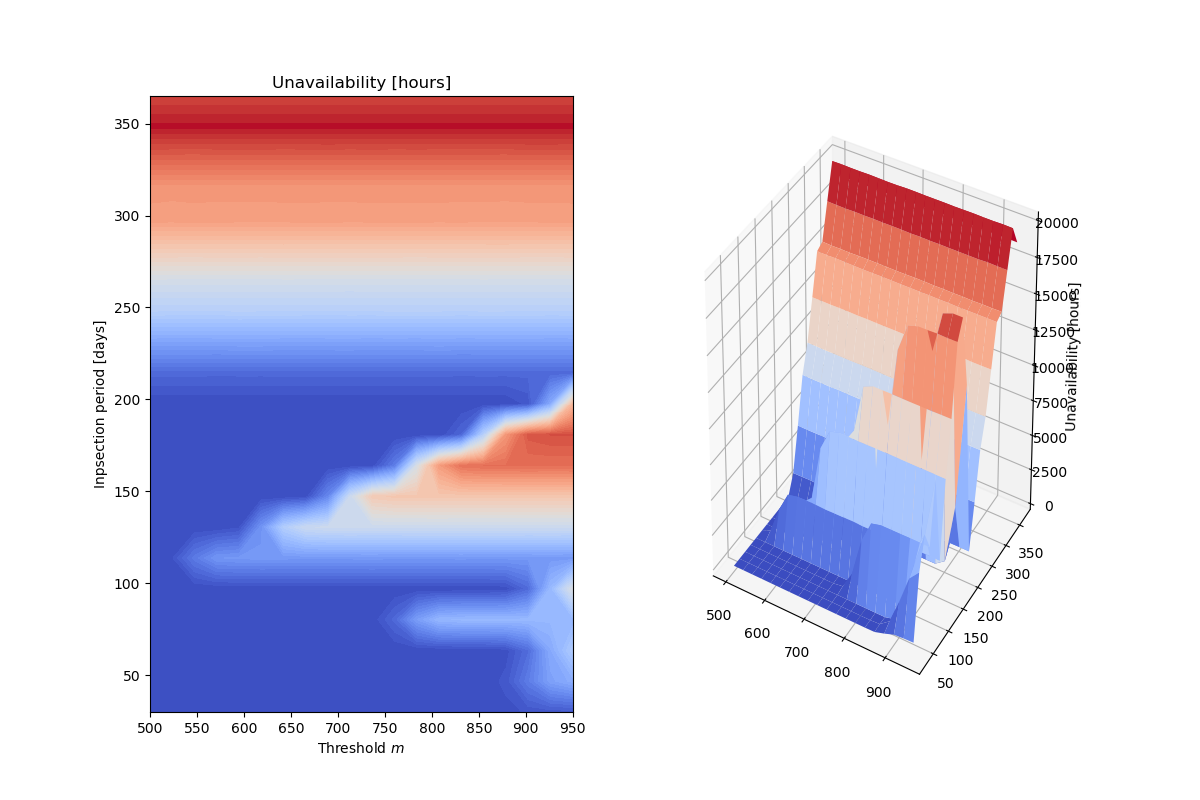

<IPython.core.display.Javascript object>


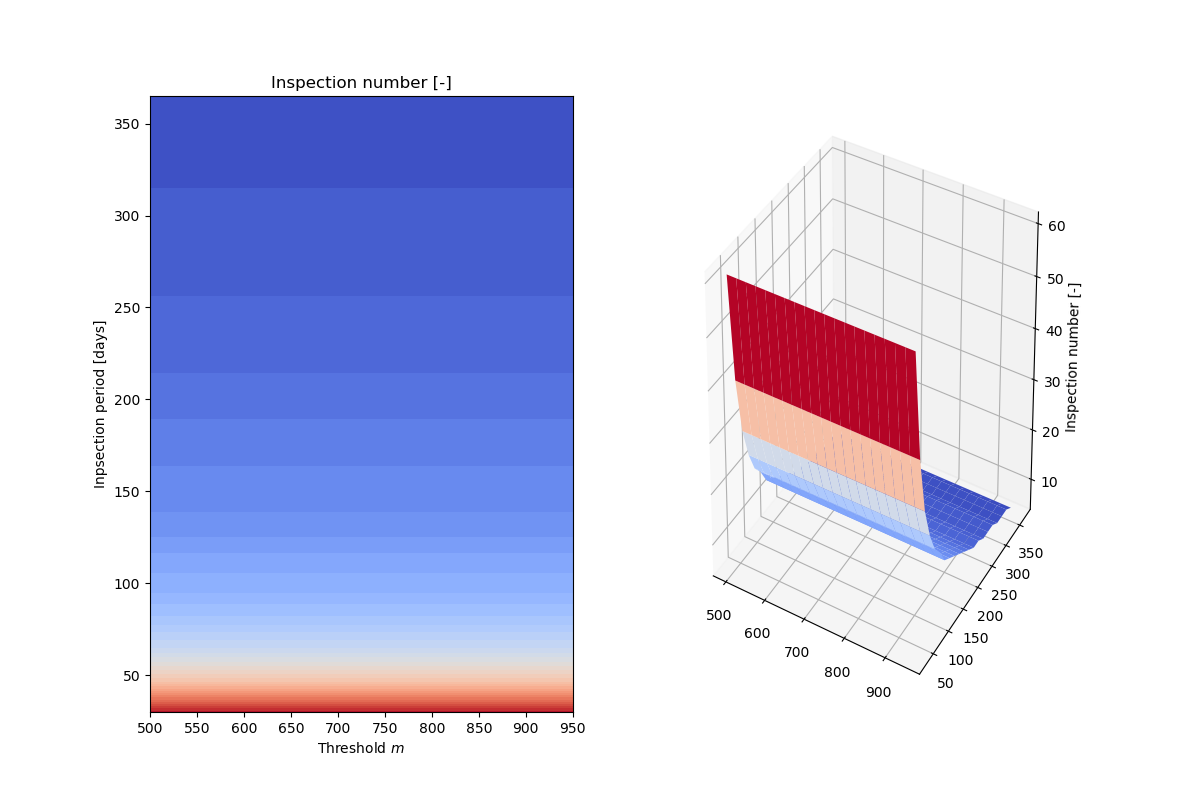

<IPython.core.display.Javascript object>


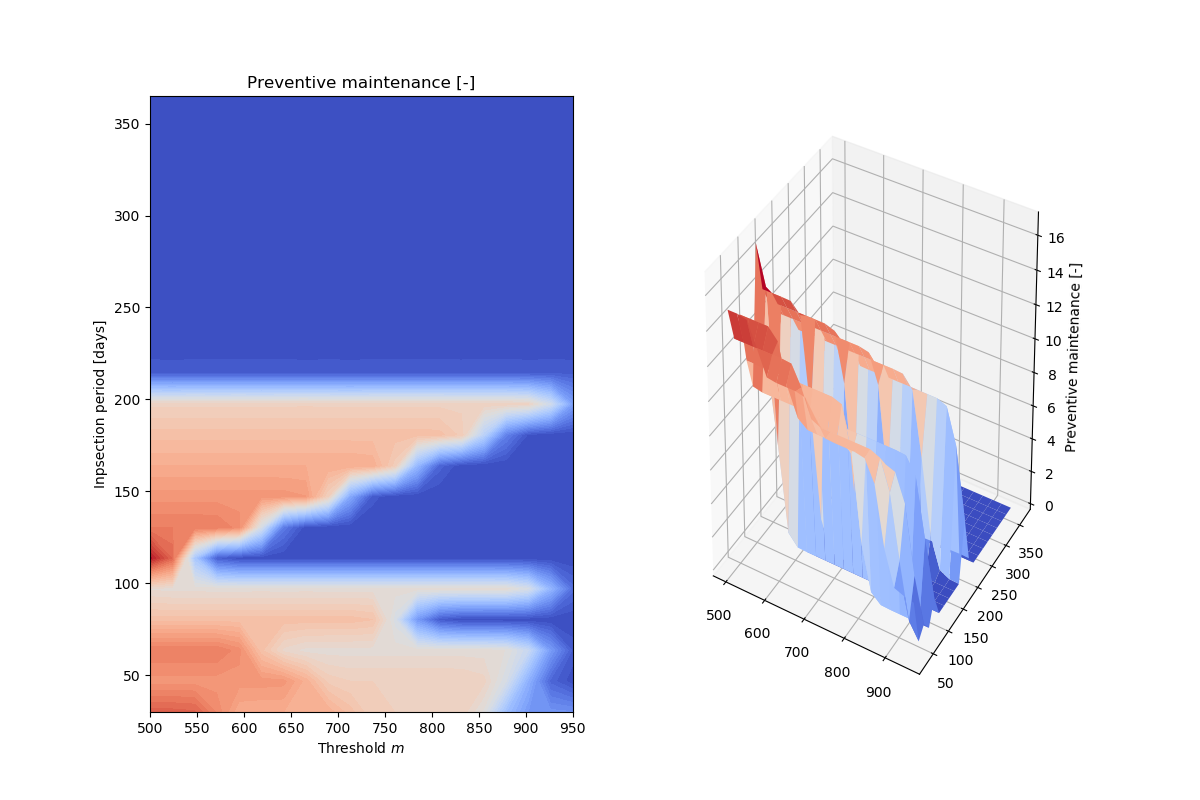

<IPython.core.display.Javascript object>


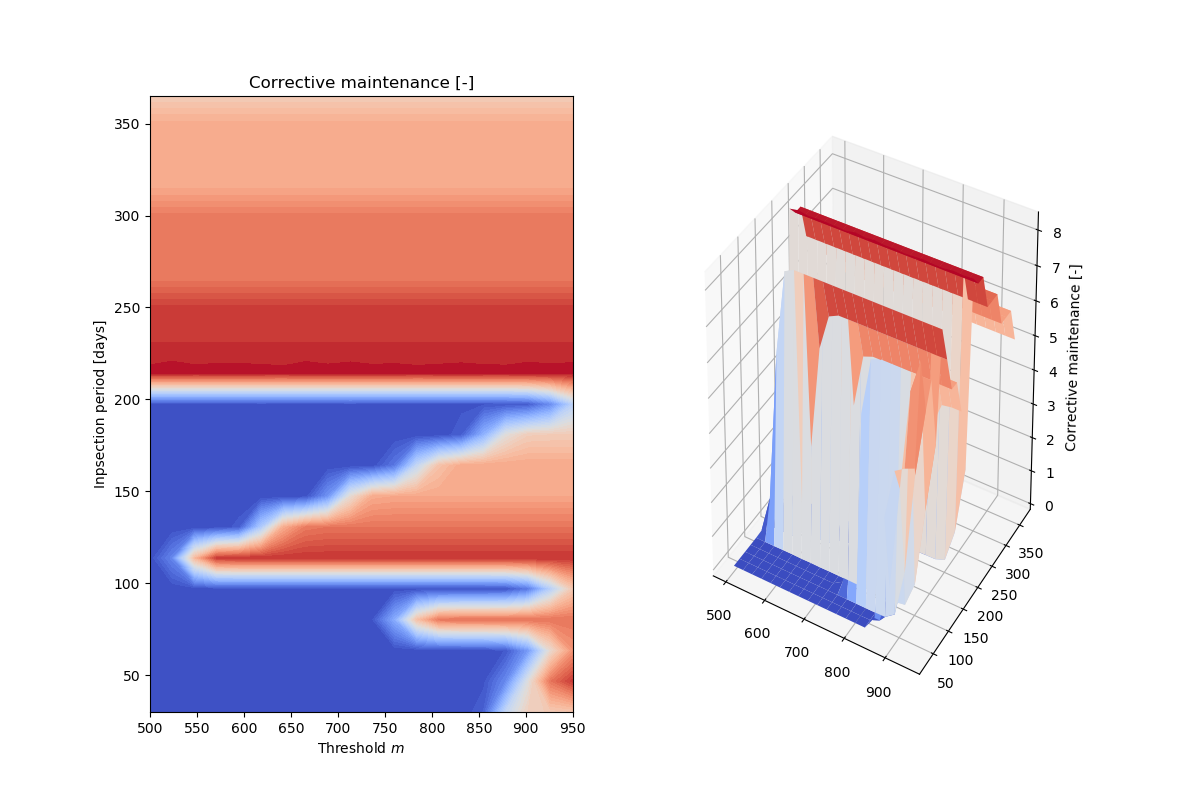

In [12]:
mMat = [mUnavailable, mNbInsp, mNbPrevMaint, mNbCorrMaint]
label = ['Unavailability [hours]', 'Inspection number [-]', 'Preventive maintenance [-]', 'Corrective maintenance [-]']
for k in range(4):
    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(1, 2, 1)
    ax.contourf(mThr, mIns, mMat[k], cmap=cm.coolwarm, levels=50)
    ax.set_xlabel('Threshold $m$')
    ax.set_ylabel('Inpsection period [days]')
    ax.set_title(label[k])
    ax = fig.add_subplot(1, 2, 2, projection='3d')
    ax.plot_surface(mThr, mIns, mMat[k], cmap=cm.coolwarm)
    ax.set_zlabel(label[k])
    ax.grid(True)